In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from bqplot import pyplot as plt
#from bqplot import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.set()

## Load dataset
consisting of all derived features.

In [2]:
df = pd.read_csv('../data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)
df = df[df.Cycle >= 1].reset_index().drop('index', axis=1)

## Increasing/decreasing-load trainng set


Helper methods for isolating heating/cooling subsets of cycles

In [3]:
def inc(cycle_df):
    start = cycle_df[cycle_df.Min==1].Time.values[0]
    end = cycle_df[cycle_df.Max==1].Time.values[0]
    return cycle_df[(cycle_df.Time > start) & (cycle_df.Time < end)]

def dec(cycle_df):
    start = cycle_df[cycle_df.Max==1].Time.values[0]
    end = cycle_df.iloc[-1:].Time.values[0]
    return cycle_df[(cycle_df.Time > start) & (cycle_df.Time < end)]

In [4]:
df_inc, df_dec = pd.DataFrame(), pd.DataFrame()
for cycle in np.arange(1, 47):
    cycle_df = df[df.Cycle==cycle].reset_index()    
    df_inc = df_inc.append(inc(cycle_df))
    df_dec = df_dec.append(dec(cycle_df))
to_drop = ['Datetime', 'index']
df_inc = df_inc.drop(to_drop, axis=1); df_dec = df_dec.drop(to_drop, axis=1)

## Automation via _GridSearchCV_
We find the best (linear) estimators for derived features of the raw dataset.

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
np.warnings.filterwarnings('ignore')

In [6]:
features = ['Time', 'Min', 'Max', 'Load', 'Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']
ests = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
param_grid = {
    'alpha': np.linspace(0.01, 10.0, 30)
    #'warm_start': [True, False]
}
scores = {}
best_est = {}
tscv = TimeSeriesSplit(n_splits=5)
X = df[df.Min==1].drop(['Datetime'], axis=1).fillna(0)

for feature in features:
    cv = None
    for i, est in enumerate(ests):
        #t_features = features[:]; t_features.remove(feature)
        t_features = ['Time', 'Cycle']
        y = X[feature]
        
        # run gridsearch cross-validation
        if i == 0:
            cv = GridSearchCV(est, {}, cv=tscv, refit=True).fit(X[t_features], y)
        else:
            cv = GridSearchCV(est, param_grid, cv=tscv, refit=True).fit(X[t_features], y)
        score = cv.score(X[t_features], y)
        
        # enumerate scores by features
        if feature in scores.keys():
            scores[feature].append(score)
        else:
            scores[feature] = [score]
            
        # store the best estimator for curve generation later
        if feature not in best_est.keys():
            best_est[feature] = (None, 0) # default score
        elif score > best_est[feature][1]: # best score
            best_est[feature] = (cv.best_estimator_, score)

In [18]:
[(feature, ('%.3f' % best_est[feature][1])) for feature in features]

[('Time', '1.000'),
 ('Min', '1.000'),
 ('Max', '1.000'),
 ('Load', '0.293'),
 ('Cycle', '1.000'),
 ('Area', '0.953'),
 ('Heating', '0.934'),
 ('Cooling', '0.569'),
 ('HCprop', '0.733'),
 ('Period', '0.773'),
 ('Tail', '0.569'),
 ('Belly', '0.716'),
 ('Kurt', '0.854'),
 ('Skew', '0.479')]

## Fit curves to cycles
regressing on all (ground truth) derived features, and predicting (fitting) `Load`.

In [23]:
def cycle_ridge(X, y):

    """
    Break cycles up into 4 subsets:
        first 50% of heating period  [h0 : h1]
        second 50% of heating period [h1 : h2]
        first 50% of cooling period  [h2 : h3]
        second 50% of cooling period [h3 : h4]
    """
    X = X.drop(['Datetime'], axis=1).fillna(0)
    h0 = X[X.Min==1].index[0]; h2 = X[X.Max==1].index[0]
    h1 = (h0+h2)//2; h4 = X.iloc[-1:].index[0]
    h3 = (h2+h4)//2
    
    curves = [X.loc[h0:h1,:], X.loc[h1:h2,:], X.loc[h2:h3,:], X.loc[h3:h4,:]]
    targets = [y.loc[h0:h1], y.loc[h1:h2], y.loc[h2:h3], y.loc[h3:h4]]
    
    steps = [('poly', PolynomialFeatures()), ('reg', Ridge())]
    ests = [Pipeline(steps) for i in range(4)]
    gcvs, limits = [], [0, h2-h1, h3-h1, h4-h1]
    param_grid = dict(poly__degree=[3],
                      reg__alpha=np.linspace(0.1, 10.0, 10))
            
    for i, est in enumerate(ests):
        cv = GridSearchCV(est, param_grid=param_grid)
        gcvs.append(cv.fit(curves[i], targets[i]).best_estimator_)
    return gcvs, limits

In [65]:
cycle = df[df.Cycle==40]
sani_cycle = cycle.drop(['Load', 'Datetime'], axis=1).fillna(0) #TEMP
ests, limits = cycle_ridge(cycle.drop('Load', axis=1), cycle.Load)

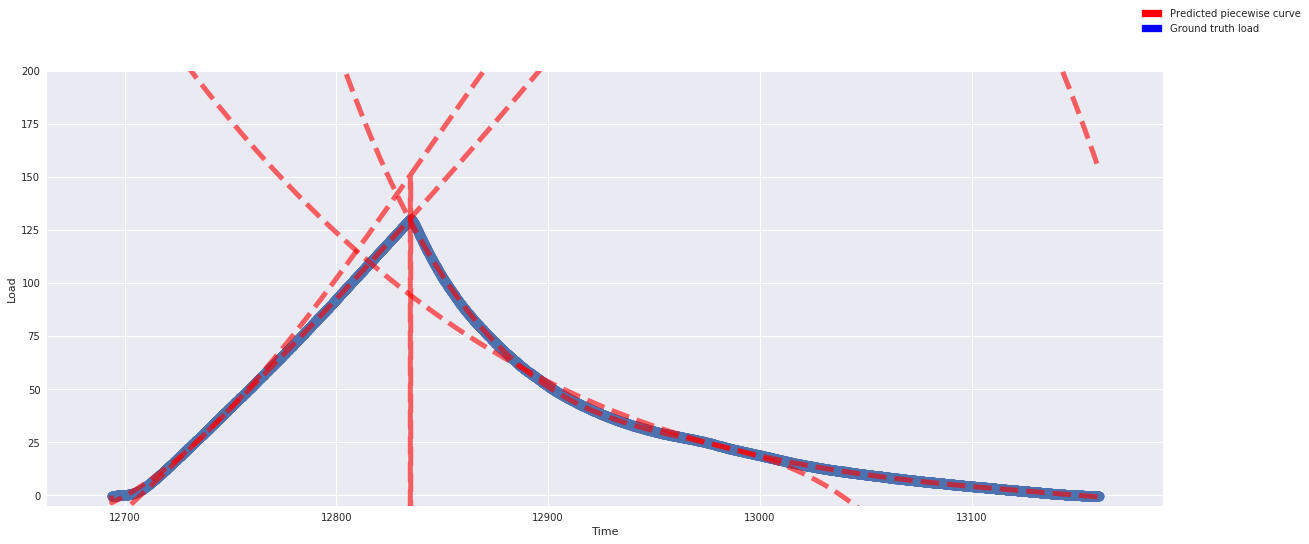

In [66]:
import matplotlib.patches as mpatches
fig, axes = plt.subplots(figsize=(20, 8))
plt.ylim(-5,200)
sns.regplot('Time', 'Load', cycle, fit_reg=False, scatter_kws={"alpha":0.7, "s":100})
for est in range(4):
    pred = ests[est].predict(sani_cycle)
    axes.plot(sani_cycle.Time, pred, linewidth=5, linestyle='--', alpha=0.6, c='r')

red_patch = mpatches.Patch(color='blue', label='Ground truth load')
blue_patch = mpatches.Patch(color='red', label='Predicted piecewise curve')
fig.legend(handles=[blue_patch, red_patch])
fig.show()

### _4_-curve generation from estimated derived features

Predict derived features for $n$th cycle based on $1 \dots (n-1)$th cycles.

In [236]:
cycle_no = 40 # n

In [237]:
X_raw = df[df.Cycle==cycle_no].drop(['Datetime'], axis=1)
X_c = X_raw.fillna(0)[df.Min==1][['Time', 'Cycle']]
X_f = pd.DataFrame()
for feature in features:
    X_f[feature] = best_est[feature][0].predict(X_c)
X_f[['Cycle']] = cycle_no

In [238]:
X_f.drop('Load', axis=1, inplace=True); X_f

,Time,Min,Max,Cycle,Area,Heating,Cooling,HCprop,Period,Tail,Belly,Kurt,Skew
0,12693.8,1.0,0.0,40.0,16593.852716,129.091462,303.72957,0.42224,432.856149,303.627895,5103.022333,-0.249269,0.960726


Predict cycle time-load characteristic based on predicted features for $n$th cycle.

In [239]:
X_t = pd.DataFrame() # this entire cell is very slow and needs to be rewritten more intelligently
start_time = X_raw.Time.values[0]
assumed_period = X_raw.shape[0]/10
for t in np.arange(start_time, start_time+assumed_period, 0.1):    
    new_row = X_f.copy(deep=True)
    new_row.Time = t
    overwrite_features = ['Min', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew'] # temp?
    if t != start_time: # awful
        for feature in overwrite_features:
            new_row[feature] = 0
    X_t = X_t.append(new_row)

In [240]:
X_t = X_t.reset_index().drop(['index'], axis=1)

In [241]:
preds = [ests[est].predict(X_t) for est in range(4)]

Graph everything.

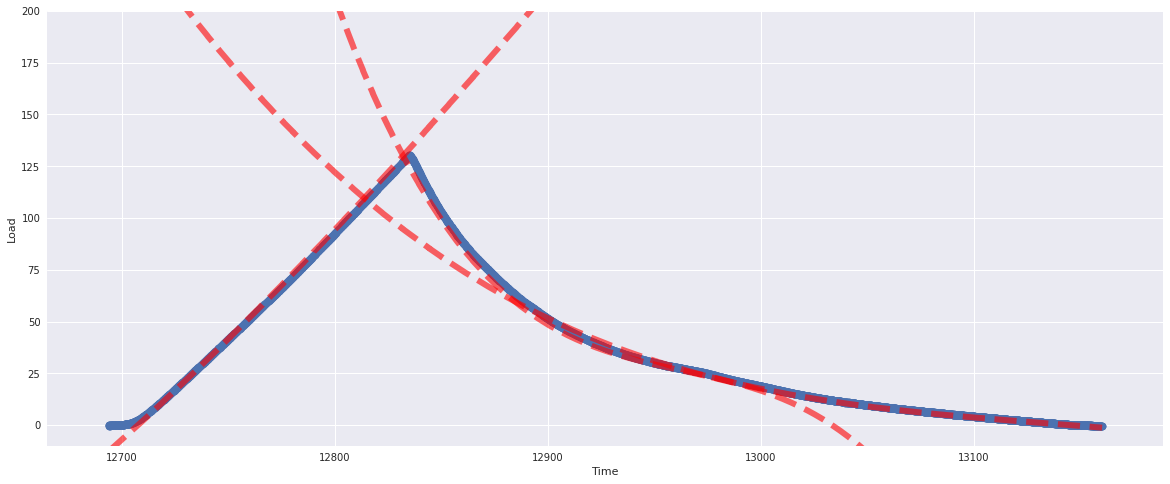

In [242]:
fig, axes = plt.subplots(figsize=(20, 8))
plt.ylim(-10, 200)
sns.regplot('Time', 'Load', X_raw, fit_reg=False, scatter_kws={"alpha":0.9,"s":60})
for pred in preds[1:]:
    axes.plot(X_raw.Time, pred, linewidth=6, linestyle='--', alpha=0.6, c='r')